In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import time
INPUT_DIR = '/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project/free-spoken-digit-dataset-master/recordings'
OUTPUT_DIR = '/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project'

# list all the files and directories within a specified directory
# parent_list = os.listdir(INPUT_DIR)
# print(len(parent_list)) # 6 speakers, 10 digits, 50 recordings for each digit
# for i in range(10):
#     print(parent_list[i])

# Convert audio files to image files

In [2]:
# only need to do once, convert audio file to images
t_process_0 = time.process_time()
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = np.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))
    for filename in os.listdir(INPUT_DIR):
        if "wav" in filename:
            file_path = os.path.join(INPUT_DIR, filename)
            file_stem = Path(file_path).stem
            target_dir = f'class_{file_stem[0]}'
            dist_dir = os.path.join(OUTPUT_DIR, 'audio-images', target_dir)
            file_dist_path = os.path.join(dist_dir, file_stem)
            if not os.path.exists(dist_dir):
                os.makedirs(dist_dir)
            if not os.path.exists(file_dist_path + '.png'):
                file_stem = Path(file_path).stem
                sound_info, frame_rate = get_wav_info(file_path)
                pylab.specgram(sound_info, Fs = frame_rate)
                plt.axis('off')
                pylab.savefig(f'{file_dist_path}.png')
                pylab.close()
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
# print("Classes: \n")
# for i in range(10):
#     print(path_list[i])

# path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
# print("\nA few example files: \n")
# for i in range(10):
#     print(path_list[i])
t_process_1 = time.process_time()
# print(t_process_1-t_process_0)

image process time 989.6 \
average time per sample to process = 0.33 (s)

# Load and Process Data


In [3]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 32
N_CHANNELS = 1
N_CLASSES = 10

directory = os.path.join(OUTPUT_DIR, 'audio-images')
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size = BATCH_SIZE,
    validation_split = 0.3,
    directory=directory,
    shuffle = True,
    color_mode = 'grayscale',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    subset = "training",
    seed = 42
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size = BATCH_SIZE,
    validation_split = 0.3,
    directory=directory,
    shuffle = True,
    color_mode = 'grayscale',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    subset = "validation",
    seed = 42
)

def split_dataset(dataset, split_fraction=0.5):
  dataset_size = len(dataset)
  split_size = int(dataset_size * split_fraction)
  # dataset = dataset.shuffle(buffer_size=dataset_size)
  return dataset.take(split_size), dataset.skip(split_size)

test_dataset, valid_dataset = split_dataset(valid_dataset, split_fraction=0.5)
print('validation dataset is further split into 50/50 test/valid dataset', '\n')
print('batch size:', BATCH_SIZE)
print('train_dataset batch numbers:', len(train_dataset))
print('valid_dataset batch numbers:', len(valid_dataset))
print('test_dataset batch numbers:', len(test_dataset))

Found 3000 files belonging to 10 classes.
Using 2100 files for training.
Found 3000 files belonging to 10 classes.
Using 900 files for validation.
validation dataset is further split into 50/50 test/valid dataset 

batch size: 32
train_dataset batch numbers: 66
valid_dataset batch numbers: 15
test_dataset batch numbers: 14


# CNN Model

In [4]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                        

In [5]:
epochs = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.01, mode='min', verbose=1)
history = model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, callbacks=[early_stopping])

Epoch 1/15
66/66 [==============================] - 3s 44ms/step - loss: 1.3807 - accuracy: 0.5714 - val_loss: 5.3621 - val_accuracy: 0.1659
Epoch 2/15
66/66 [==============================] - 3s 43ms/step - loss: 0.4495 - accuracy: 0.8624 - val_loss: 3.9506 - val_accuracy: 0.2699
Epoch 3/15
66/66 [==============================] - 3s 40ms/step - loss: 0.2663 - accuracy: 0.9214 - val_loss: 1.8510 - val_accuracy: 0.4912
Epoch 4/15
66/66 [==============================] - 3s 41ms/step - loss: 0.1814 - accuracy: 0.9519 - val_loss: 1.2819 - val_accuracy: 0.5686
Epoch 5/15
66/66 [==============================] - 3s 42ms/step - loss: 0.1369 - accuracy: 0.9657 - val_loss: 1.1872 - val_accuracy: 0.6704
Epoch 6/15
66/66 [==============================] - 3s 40ms/step - loss: 0.1239 - accuracy: 0.9667 - val_loss: 0.3385 - val_accuracy: 0.8827
Epoch 7/15
66/66 [==============================] - 3s 44ms/step - loss: 0.0936 - accuracy: 0.9771 - val_loss: 0.3056 - val_accuracy: 0.9181
Epoch 8/15
66

In [6]:
# # Plot the loss curves for training and validation.
# history_dict = history.history
# loss_values = history_dict['loss']
# val_loss_values = history_dict['val_loss']
# epochs = range(1, len(loss_values)+1)

# plt.figure(figsize=(8,6))
# plt.plot(epochs, loss_values, 'bo', label='Training loss')
# plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [7]:
# # Plot the accuracy curves for training and validation.
# acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_accuracy']
# epochs = range(1, len(acc_values)+1)

# plt.figure(figsize=(8,6))
# plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
# plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [8]:
# # Compute the final loss and accuracy
# final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
# print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

In [9]:
# print(model.summary())

In [10]:
import time

# Start the timer.
t0 = time.process_time()


final_loss, final_acc = model.evaluate(test_dataset, verbose=0)

# Stop the timer.0
t1 = time.process_time()

# print((t1-t0), len(valid_dataset), 'batches')
avg_time = (t1 - t0) / len(valid_dataset) / 30
print("Average time per sample: ", avg_time)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

# penalty = ... # whatever, we'll find this out later.
# adjusted_acc = final_acc / (1 + penalty * avg_time)

# print("Time adjusted final accuracy: {1:.6f}".format(adjusted_acc))

Average time per sample:  0.009591511111111117
Final loss: 0.358587, final accuracy: 0.897321


5.33727300000001 15 batches
Average time per batch:  0.3558182000000007
Final loss: 0.291075, final accuracy: 0.900000 \
5.325380999999993 15 batches
Average time per batch:  0.35502539999999955
Final loss: 0.170305, final accuracy: 0.955357 \
5.40189300000003 15 batches
Average time per batch:  0.36012620000000195
Final loss: 0.292220, final accuracy: 0.928571 \
5.467108999999994 15 batches
Average time per batch:  0.3644739333333329
Final loss: 0.384134, final accuracy: 0.897321

In [35]:
# X_test, y_test = for x, y in test_dataset
# X_test
# y_test
# for x, y in test_dataset:
#     np.concatenate(X_test, (x.numpy()))
#     y_test.append([y.numpy()])
#     print(x.shape)
# print(type(X_test))
# X_test, y_test= ((np.concatenate([x.numpy()]), np.concatenate([y.numpy()])) for x, y in test_dataset)
# # y_test = np.concatenate([y.numpy() for x, y in test_dataset])
# y2_test = np.concatenate([y.numpy() for x, y in test_dataset])

In [91]:
from itertools import tee

In [95]:
temp = test_dataset.as_numpy_iterator()
temp, temp2 = tee(temp)

In [96]:
testing = temp
arrays = [y for x, y in temp2]

In [97]:
true_classes = []
for array in arrays:
    true_classes.extend(array)

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
predictions = model.predict(temp, verbose=0)
print(len(predictions))
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels from batches
# true_classes = np.concatenate([y.numpy() for x, y in testing])
# true_classes = true_classes[np.logical_not(np.isnan(true_classes))]
# Create confusion matrix
print(predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the matrix
print(cm)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy}")

448
[4 4 2 3 4 0 4 7 2 2 0 1 9 1 2 1 2 7 0 3 1 0 6 9 7 4 8 2 8 6 8 1 1 1 2 0 7
 1 9 6 0 2 4 0 6 0 1 9 4 8 7 2 1 8 6 2 5 5 2 1 9 2 2 4 9 6 3 7 3 4 3 0 2 0
 8 2 4 1 4 0 1 6 6 8 0 7 4 6 3 0 7 9 4 6 4 5 4 1 4 1 7 6 8 5 7 6 7 8 8 0 1
 3 0 8 9 9 6 0 4 1 7 4 6 5 2 5 3 9 3 8 1 6 4 4 2 5 7 0 7 2 0 8 9 6 2 8 3 6
 6 8 9 2 2 3 3 3 0 9 0 1 0 6 8 9 0 7 3 8 9 4 7 6 5 8 3 1 6 6 5 5 2 0 1 4 0
 8 7 5 4 3 6 8 8 4 7 0 1 3 6 2 6 7 2 4 6 9 3 1 9 6 3 0 2 5 8 6 6 3 1 3 7 1
 2 2 1 4 9 5 4 5 4 9 5 5 1 9 2 6 7 7 4 6 0 6 2 6 2 8 0 2 6 6 1 2 6 6 2 1 7
 0 5 2 4 8 1 9 3 6 2 2 6 3 1 8 3 8 4 6 9 0 9 6 7 7 5 2 5 1 2 3 5 1 5 0 0 0
 9 1 5 1 8 6 8 5 6 4 0 4 5 7 3 3 1 1 9 8 1 6 6 2 0 8 6 0 9 0 8 3 3 4 0 1 5
 1 3 6 9 3 0 2 7 7 9 7 3 8 9 9 0 3 7 0 3 7 1 5 0 9 5 6 0 8 8 4 9 3 8 9 0 9
 7 6 7 4 2 0 8 5 4 4 1 3 0 6 4 5 4 7 0 4 6 1 8 1 6 6 5 9 2 9 8 2 1 5 9 5 2
 1 2 8 6 7 3 4 2 7 6 0 8 9 0 6 9 1 2 8 7 1 2 3 3 4 9 2 8 6 7 3 6 2 6 2 5 1
 4 6 3 8]
[[49  0  2  0  1  0  1  0  0  0]
 [ 0 45  0  0  0  0  0  0  0  0]
 [ 0  0 48  1  1  0 

In [ ]:
print(true_classes)
print(predicted_classes)

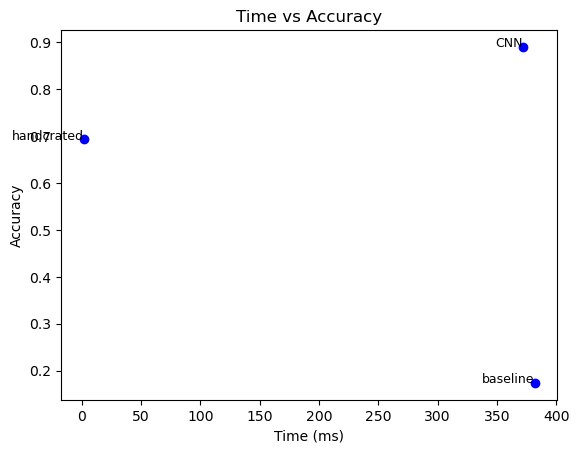

In [103]:
import matplotlib.pyplot as plt
import math
times = [0.382, 0.372, 0.001835]
for i in range(len(times)):
    times[i] *= 1000
accuracies = [0.1738, 0.89, 0.693]
labels = ['baseline', 'CNN', 'handcrated']

plt.scatter(times, accuracies, color='blue')
for i in range(len(times)):
    plt.text(times[i], accuracies[i], labels[i], fontsize=9, ha='right')

plt.title('Time vs Accuracy')
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy')

plt.show()

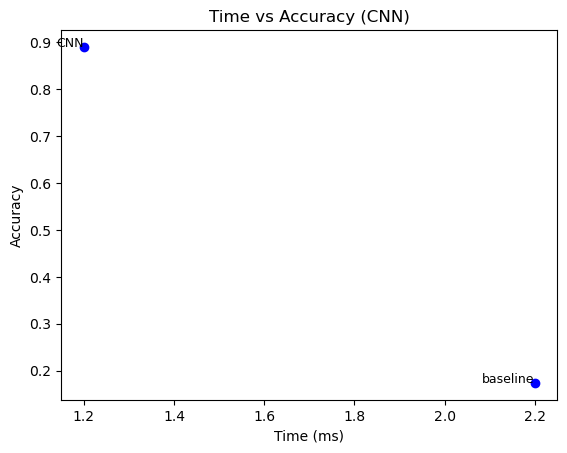

In [104]:
times = [2.2, 1.2]
accuracies = [0.1738, 0.89]
labels = ['baseline', 'CNN']

plt.scatter(times, accuracies, color='blue')
for i in range(len(times)):
    plt.text(times[i], accuracies[i], labels[i], fontsize=9, ha='right')

plt.title('Time vs Accuracy (CNN)')
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy')

plt.show()

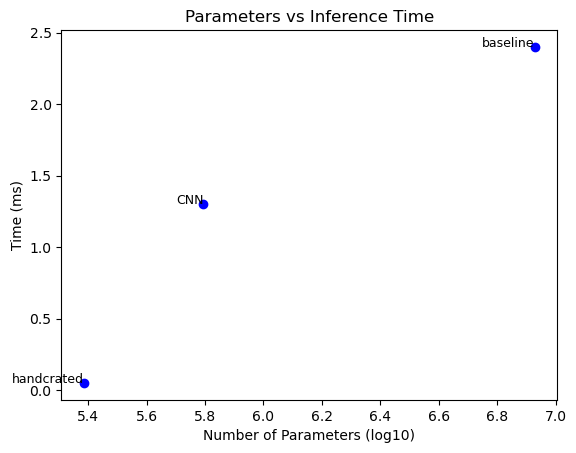

In [108]:
parameters = [8487498, 622602, 243000]
for i in range(len(parameters)):
    parameters[i] = math.log(parameters[i], 10)
accuracies = [2.4, 1.3, 0.05]
labels = ['baseline', 'CNN', 'handcrated']
# Creating the scatter plot
plt.scatter(parameters, accuracies, color='blue')
for i in range(len(parameters)):
    plt.text(parameters[i], accuracies[i], labels[i], fontsize=9, ha='right')
# Adding title and labels
plt.title('Parameters vs Inference Time')
plt.xlabel('Number of Parameters (log10)')
plt.ylabel('Time (ms)')
# Show the plot
plt.show()

In [99]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import time
INPUT_DIR = '/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project/handcrafted/data'
OUTPUT_DIR = '/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project/handcrafted'

# list all the files and directories within a specified directory
parent_list = os.listdir(INPUT_DIR)
print(len(parent_list))
# for i in range(len(parent_list)):
    # print(parent_list[i])
# for filename in os.listdir(INPUT_DIR):
#     print(filename)

62


In [100]:
# only need to do once, convert audio file to images
INPUT_DIR = '/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project/handcrafted/audios'
t_process_0 = time.process_time()
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = np.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
    
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))
    for filename in os.listdir(INPUT_DIR):
        
        if "wav" in filename:
            file_path = os.path.join(INPUT_DIR, filename)
            file_stem = Path(file_path).stem
            target_dir = f'class_{file_stem[0]}'
            dist_dir = os.path.join(OUTPUT_DIR, 'audio-images', target_dir)
            file_dist_path = os.path.join(dist_dir, file_stem)
            if not os.path.exists(dist_dir):
                os.makedirs(dist_dir)
            if not os.path.exists(file_dist_path + '.png'):
                file_stem = Path(file_path).stem
                sound_info, frame_rate = get_wav_info(file_path)
                pylab.specgram(sound_info, Fs = frame_rate)
                plt.axis('off')
                pylab.savefig(f'{file_dist_path}.png')
                pylab.close()
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
# print("Classes: \n")
# for i in range(10):
#     print(path_list[i])

# path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
# print("\nA few example files: \n")
# for i in range(10):
#     print(path_list[i])
t_process_1 = time.process_time()
# print(t_process_1-t_process_0)

In [101]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 32
N_CHANNELS = 1
N_CLASSES = 10

directory = os.path.join(OUTPUT_DIR, 'audio-images')
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size = BATCH_SIZE,
    validation_split = 0.3,
    directory=directory,
    shuffle = True,
    color_mode = 'grayscale',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    subset = "training",
    seed = 42
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size = BATCH_SIZE,
    validation_split = 0.3,
    directory=directory,
    shuffle = True,
    color_mode = 'grayscale',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    subset = "validation",
    seed = 42
)

def split_dataset(dataset, split_fraction=0.5):
  dataset_size = len(dataset)
  split_size = int(dataset_size * split_fraction)
  dataset = dataset.shuffle(buffer_size=dataset_size)
  return dataset.take(split_size), dataset.skip(split_size)

test_dataset, valid_dataset = split_dataset(valid_dataset, split_fraction=0.5)
print('validation dataset is further split into 50/50 test/valid dataset', '\n')
print('batch size:', BATCH_SIZE)
print('train_dataset batch numbers:', len(train_dataset))
print('valid_dataset batch numbers:', len(valid_dataset))
print('test_dataset batch numbers:', len(test_dataset))

Found 30000 files belonging to 10 classes.
Using 21000 files for training.
Found 30000 files belonging to 10 classes.
Using 9000 files for validation.
validation dataset is further split into 50/50 test/valid dataset 

batch size: 32
train_dataset batch numbers: 657
valid_dataset batch numbers: 141
test_dataset batch numbers: 141


In [102]:
from itertools import tee
temp = test_dataset.as_numpy_iterator()
temp, temp2 = tee(temp)
testing = temp
arrays = [y for x, y in temp2]
true_classes = []
for array in arrays:
    true_classes.extend(array)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
predictions = model.predict(temp, verbose=0)
print(len(predictions))
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels from batches
# true_classes = np.concatenate([y.numpy() for x, y in testing])
# true_classes = true_classes[np.logical_not(np.isnan(true_classes))]
# Create confusion matrix
print(predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the matrix
print(cm)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy}")

4512
[2 3 1 ... 2 2 2]
[[  0   1 403  60   0   0   0   0   0   0]
 [  0   0 444   3   0   0   0   0   0   0]
 [  0   1 381  32   0   0   0   0   0   0]
 [  0   0 280 137   2   0   0   0   0   0]
 [  0   0 405  36   0   0   0   0   0   0]
 [  0   0 395  54   2   0   3   0   0   1]
 [  0  10 209   0 108   0 135   1   0   0]
 [  0  15 294 162   0   0   0   0   0   1]
 [  6  16 384   4  14   0  30   0   1   0]
 [  0   0 462  20   0   0   0   0   0   0]]
Accuracy: 0.1449468085106383
